<a href="https://colab.research.google.com/github/nisarahamedk/Kaggle_Notebooks/blob/master/melanoma_classification/01_combine_context_and_external_data_to_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Combine context + external data into TFRecords for TPU training.

#### GCSFS for accessing Kaggle GCS bucket directly

In [0]:
%%capture
!pip install gcsfs
!pip install ray
!pip install kaggle

### Imports

In [0]:
from pathlib import Path
import gcsfs
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import ray

import warnings
warnings.filterwarnings("ignore")

In [0]:
# isic 2020
GCS_PATH_ORIG = "gs://kds-5d7ff9ec38e07108d627f4d70f909368b22bdeb64b7b6134f6abb8a1"
GCS_PATH_ORIG_TFR = GCS_PATH_ORIG + "/tfrecords"
GCS_PATH_ORIG_JPEG_TRAIN = GCS_PATH_ORIG + "/jpeg/train/"
GCS_PATH_ORIG_JPEG_TEST = GCS_PATH_ORIG + "/jpeg/test/"
GCS_PATH_ORIG_TRAIN_CSV = GCS_PATH_ORIG + "/train.csv"
GCS_PATH_ORIG_TEST_CSV = GCS_PATH_ORIG + "/test.csv"

# isic 2019
GCS_PATH_EXT = "gs://kds-c8a304a051784049f9397a87261baf056d20becc00b481671a0cefb9"
GCS_PATH_EXT_TRAIN_CSV = GCS_PATH_EXT + "/ISIC_2019_Training_GroundTruth.csv"
GCS_PATH_EXT_TRAIN_META = GCS_PATH_EXT + "/ISIC_2019_Training_Metadata.csv"
GCS_PATH_EXT_JPEG_TRAIN = GCS_PATH_EXT + "/ISIC_2019_Training_Input/ISIC_2019_Training_Input/"

### ISIC 2020 Original Data

In [17]:
orig_train_df = pd.read_csv(GCS_PATH_ORIG_TRAIN_CSV)
orig_train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


0    32542
1      584
Name: target, dtype: int64


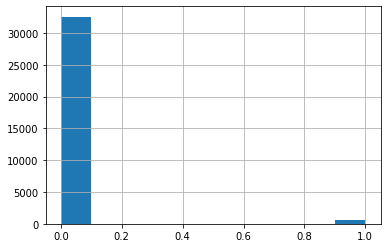

In [18]:
print(orig_train_df["target"].value_counts())
orig_train_df["target"].hist()

In [19]:
orig_test_df = pd.read_csv(GCS_PATH_ORIG_TEST_CSV)
orig_test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


Above the tabular features we have.  

Actual images in jpeg

In [20]:
orig_images = tf.io.gfile.glob(GCS_PATH_ORIG_JPEG_TRAIN + "*.jpg")
print("Original Images: ", orig_images[:4])
ext_images = tf.io.gfile.glob(GCS_PATH_EXT_JPEG_TRAIN + "*.jpg")
print("External Images: ", ext_images[:4])

Original Images:  ['gs://kds-5d7ff9ec38e07108d627f4d70f909368b22bdeb64b7b6134f6abb8a1/jpeg/train/ISIC_0015719.jpg', 'gs://kds-5d7ff9ec38e07108d627f4d70f909368b22bdeb64b7b6134f6abb8a1/jpeg/train/ISIC_0052212.jpg', 'gs://kds-5d7ff9ec38e07108d627f4d70f909368b22bdeb64b7b6134f6abb8a1/jpeg/train/ISIC_0068279.jpg', 'gs://kds-5d7ff9ec38e07108d627f4d70f909368b22bdeb64b7b6134f6abb8a1/jpeg/train/ISIC_0074268.jpg']
External Images:  ['gs://kds-c8a304a051784049f9397a87261baf056d20becc00b481671a0cefb9/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000000.jpg', 'gs://kds-c8a304a051784049f9397a87261baf056d20becc00b481671a0cefb9/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000001.jpg', 'gs://kds-c8a304a051784049f9397a87261baf056d20becc00b481671a0cefb9/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000002.jpg', 'gs://kds-c8a304a051784049f9397a87261baf056d20becc00b481671a0cefb9/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0000003.jpg']


###  External Data - ISIC 2019

In [21]:
ext_train_df = pd.read_csv(GCS_PATH_EXT_TRAIN_CSV)
ext_train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Only image names is important to us.  
The other columns are skin lesion class. our target variable is MEL - that is Melanoma.
Other features are available in.

In [22]:
ext_meta_df = pd.read_csv(GCS_PATH_EXT_TRAIN_META)
ext_meta_df.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


#### Features

Features available both the dataset.  

* ```image_name```
* ```age_approx```
* ```anatom_site```
* ```sex```
* ```patient_id``` / ```lesion_id```

Feature in original but not in external

* ```diagnosis```

#### Label

* Original data - ```target``` column
* External data - ```MEL``` 
* Can the other target columns in Ext data be used as the ```diagnosis``` feature?

### The Diagnosis Feature

* In the original dataset we have a column ```diagnosis```
* In the ext dataset, our labels are actually diagnosis classes.
* But the nomenclature is a bit different.

#### Original

In [23]:
orig_train_df["diagnosis"].value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

#### External

In [24]:
ext_train_df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Looking at this article. : https://challenge2019.isic-archive.com/
* we can merge both the datasets` diagnosis feature.
  * Melanoma - Present in both, as MEL in EXT
  * Nevus - Present in both, as NV in EXT.
  * seborrheic keratosis, solar lentigo, lichenoid keratosis - as BKL in EXT
  * Lentigo NOS in ORIG - not in EXT
  * cafe-au-lait macule in ORIG - not in EXT
  * atypical melanocytic proliferation in ORIG - not in EXT
  * BCC in EXT - not in ORIG
  * AK in EXT - not in ORIG
  * DF in EXT - not in ORIG
  * VASC in EXT - not in ORIG
  * SCC in EXT - not in ORIG

### Combine both ORIG and EXT dataframe

In [25]:
# https://www.kaggle.com/shonenkov/merge-external-data

# convert diagsnois str to a key that matches external dataset.
diagnosis_key = {
    "melanoma"            : "MEL",
    "nevus"               : "NV",
    "seborrheic keratosis": "BKL",
    "lichenoid keratosis" : "BKL",
    "solar lentigo"       : "BKL",
    "lentigo NOS"         : "LNOS",
    "cafe-au-lait macule" : "CALM",
    "atypical melanocytic proliferation": "AMP",
    "unknown"             : "UNK",
}

dataset = {
    'patient_id' : [],
    'image_id': [],
    'source': [],
    'sex': [],
    'age_approx': [],
    'anatom_site_general_challenge': [],
    'diagnosis': [],
    'target': [],
}

# isic2020
df_train = pd.read_csv(GCS_PATH_ORIG_TRAIN_CSV, index_col='image_name')
for image_id, row in tqdm(df_train.iterrows(), total=df_train.shape[0]):
    if image_id in dataset['image_id']:
        continue
    dataset['patient_id'].append(row['patient_id'])
    dataset['image_id'].append(image_id)
    dataset['target'].append(row['target'])
    dataset['source'].append('ISIC20')
    dataset['sex'].append(row['sex'])
    dataset['age_approx'].append(row['age_approx'])
    dataset['anatom_site_general_challenge'].append(row['anatom_site_general_challenge'])
    dataset['diagnosis'].append(diagnosis_key[row['diagnosis']])

# isic2019
df_gt = pd.read_csv(GCS_PATH_EXT_TRAIN_CSV, index_col='image')
df_meta = pd.read_csv(GCS_PATH_EXT_TRAIN_META, index_col='image')
for image_id, row in tqdm(df_meta.iterrows(), total=df_meta.shape[0]):
    if image_id in dataset['image_id'] or "downsampled" in image_id.lower(): # duplicate images in external as per: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155859#878163
        continue

    dataset['patient_id'].append(row['lesion_id'])
    dataset['image_id'].append(image_id)
    dataset['target'].append(int(df_gt.loc[image_id]['MEL']))
    dataset['source'].append('ISIC19')
    dataset['sex'].append(row['sex'])
    dataset['age_approx'].append(row['age_approx'])
    dataset['anatom_site_general_challenge'].append(
        {'anterior torso': 'torso', 'posterior torso': 'torso', 'lateral torso': 'torso'}.get(row['anatom_site_general'], row['anatom_site_general'])
    )
    # diagnosis
    bool_mask = df_gt.loc[image_id].eq(1) # gives True for the column where 1 and False for others
    diagnosis = bool_mask.index[bool_mask][0]
    dataset['diagnosis'].append(diagnosis)

100%|██████████| 25331/25331 [00:37<00:00, 668.32it/s]


In [26]:
combined_df = pd.DataFrame(dataset)
combined_df.head()

,patient_id,image_id,source,sex,age_approx,anatom_site_general_challenge,diagnosis,target
0,IP_7279968,ISIC_2637011,ISIC20,male,45.0,head/neck,UNK,0
1,IP_3075186,ISIC_0015719,ISIC20,female,45.0,upper extremity,UNK,0
2,IP_2842074,ISIC_0052212,ISIC20,female,50.0,lower extremity,NV,0
3,IP_6890425,ISIC_0068279,ISIC20,female,45.0,head/neck,UNK,0
4,IP_8723313,ISIC_0074268,ISIC20,female,55.0,upper extremity,UNK,0


#### Impute missing values

In [27]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56383 entries, 0 to 56382
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patient_id                     55557 non-null  object 
 1   image_id                       56383 non-null  object 
 2   source                         56383 non-null  object 
 3   sex                            56114 non-null  object 
 4   age_approx                     56092 non-null  float64
 5   anatom_site_general_challenge  53973 non-null  object 
 6   diagnosis                      56383 non-null  object 
 7   target                         56383 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 3.4+ MB


In [0]:
combined_df["patient_id"].fillna("UNKNOWN_ID", inplace=True)
combined_df["sex"].fillna("Unknown", inplace=True)
combined_df["age_approx"].fillna(0.0, inplace=True)
combined_df["anatom_site_general_challenge"].fillna("Unknown", inplace=True)

### Some Histogram Check

#### Data Source

ISIC20    33126
ISIC19    23257
Name: source, dtype: int64


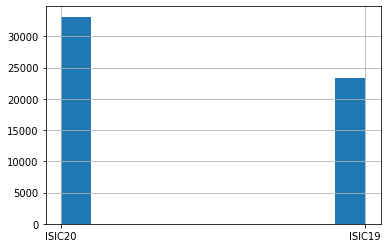

In [29]:
print(combined_df['source'].value_counts())
combined_df['source'].hist()

#### Target distribution

0    51651
1     4732
Name: target, dtype: int64


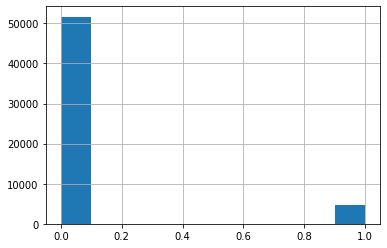

In [30]:
print(combined_df["target"].value_counts())
combined_df["target"].hist()

#### Gender distribution

male       29359
female     26755
Unknown      269
Name: sex, dtype: int64


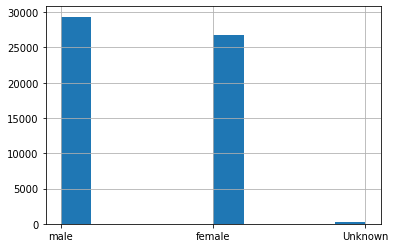

In [31]:
print(combined_df["sex"].value_counts())
combined_df["sex"].hist()

#### Lesion Location Distribution

torso              26000
lower extremity    13151
upper extremity     7632
head/neck           6241
Unknown             2410
palms/soles          766
oral/genital         183
Name: anatom_site_general_challenge, dtype: int64


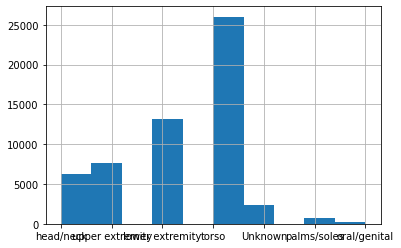

In [32]:
print(combined_df["anatom_site_general_challenge"].value_counts())
combined_df["anatom_site_general_challenge"].hist()

#### Age Distribution

45.0    6880
50.0    6606
55.0    5857
40.0    5695
60.0    5101
65.0    4441
35.0    4403
70.0    3921
30.0    3468
75.0    2658
25.0    2144
80.0    1789
85.0    1398
20.0    1023
0.0      347
15.0     326
10.0     136
5.0      110
90.0      80
Name: age_approx, dtype: int64


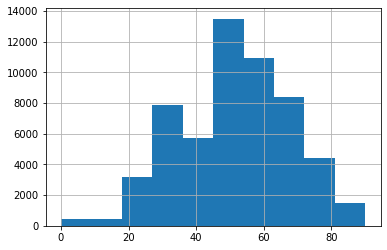

In [33]:
print(combined_df["age_approx"].value_counts())
combined_df["age_approx"].hist()

#### Diagnosis Distribution

UNK     27124
NV      16752
MEL      4732
BCC      3323
BKL      2419
AK        867
SCC       628
VASC      253
DF        239
LNOS       44
AMP         1
CALM        1
Name: diagnosis, dtype: int64


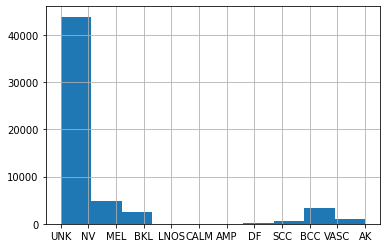

In [34]:
print(combined_df["diagnosis"].value_counts())
combined_df["diagnosis"].hist()

#### # of images per patient

In [35]:
print(combined_df["patient_id"].value_counts())

UNKNOWN_ID     826
IP_7279968     115
IP_4479736     115
IP_4382720     115
IP_4938382     115
              ... 
HAM_0002927      1
HAM_0002474      1
HAM_0004919      1
HAM_0004457      1
HAM_0003077      1
Name: patient_id, Length: 13106, dtype: int64


### Creating TFRecords - Image + Context

TODO: We may have to consider the cross validation policies while creating TFRecords

In [0]:
# https://www.tensorflow.org/tutorials/load_data/tfrecord

# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [0]:
def serialize_example(patient_id, image_id, image, source, sex, age_approx, anatom_site_general_challenge, diagnosis, target):
  feature = {
      'patient_id': _bytes_feature(patient_id),
      'image_id': _bytes_feature(image_id),
      'image': _bytes_feature(image),
      'source': _bytes_feature(source),
      'sex': _bytes_feature(sex),
      'age_approx': _int64_feature(age_approx),
      'anatom_site_general_challenge': _bytes_feature(anatom_site_general_challenge),
      'diagnosis': _bytes_feature(diagnosis),
      'target': _int64_feature(target)
  }
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

Lets create separate tfrecord files for ORIGINAL and EXT datasets

In [0]:
orig_train_df = combined_df[combined_df["source"] == "ISIC20"]
ext_train_df = combined_df[combined_df["source"] == "ISIC19"]

In [39]:
len(orig_train_df), len(ext_train_df)

(33126, 23257)

#### Using Ray to parallelize the tfrecord creation process

In [40]:
ray.shutdown()
ray.init(num_cpus=32)

2020-06-11 04:03:49,742	INFO resource_spec.py:212 -- Starting Ray with 7.52 GiB memory available for workers and up to 3.76 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-11 04:03:50,410	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-06-11_04-03-49_738280_2547/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2020-06-11_04-03-49_738280_2547/sockets/raylet',
 'redis_address': '172.28.0.2:59425',
 'session_dir': '/tmp/ray/session_2020-06-11_04-03-49_738280_2547',
 'webui_url': 'localhost:8265'}

In [0]:
@ray.remote
def create_tfrecord_from_df(df, part, source_image_dir, dest_dir="data", ds_type="train_orig"):
  size = len(df)

  print(f"Creating {ds_type}_part_{part}_{size}.tfrec, with {size} records")
  with tf.io.TFRecordWriter(f"{dest_dir}/{ds_type}_part_{part}_{size}.tfrec") as writer:
    for index, row in df.iterrows():
      patient_id = row["patient_id"]
      image_id = row["image_id"]
      image = tf.io.read_file(source_image_dir + image_id + ".jpg")
      # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Fix incorrect colors, need this?a
      source = row["source"]
      sex = row["sex"]
      age_approx = row["age_approx"]
      anatom_site_general_challenge = row["anatom_site_general_challenge"]
      diagnosis = row["diagnosis"]
      target = row["target"]

      example = serialize_example(
          patient_id=patient_id.encode(),
          image_id=image_id.encode(),
          image=image,
          source=source.encode(),
          sex=sex.encode(),
          age_approx=int(age_approx),
          anatom_site_general_challenge=anatom_site_general_challenge.encode(),
          diagnosis=diagnosis.encode(),
          target=target,
      )
      writer.write(example)
  print(f"{dest_dir}/{ds_type}_part_{part}_{size}.tfrec Created!")


In [0]:
def create_tfrecords_from_df(df, n_files=16):
  
  data_dir = Path()/"data"
  data_dir.mkdir(exist_ok=True)

  orig_train_df = df[df["source"] == "ISIC20"]
  ext_train_df = df[df["source"] == "ISIC19"]

  dfs_split_orig = np.array_split(orig_train_df, n_files)
  dfs_split_ext = np.array_split(ext_train_df, n_files)

  futures = []
  for part, df in enumerate(dfs_split_orig):
    futures.append(create_tfrecord_from_df.remote(
        df, 
        part=part, 
        source_image_dir=GCS_PATH_ORIG_JPEG_TRAIN, 
        dest_dir=str(data_dir), 
        ds_type="train_orig"
        )
    )
  
  for part, df in enumerate(dfs_split_ext):
    futures.append(create_tfrecord_from_df.remote(
        df, 
        part=part, 
        source_image_dir=GCS_PATH_EXT_JPEG_TRAIN, 
        dest_dir=str(data_dir), 
        ds_type="train_ext"
        )
    )

  ray.get(futures)

In [43]:
%%capture
%%time
create_tfrecords_from_df(combined_df)

(pid=3257) data/train_orig_part_15_2070.tfrec Created!


In [64]:
ext_train_df.head()

,patient_id,image_id,source,sex,age_approx,anatom_site_general_challenge,diagnosis,target
33126,UNKNOWN_ID,ISIC_0000000,ISIC19,female,55.0,torso,NV,0
33127,UNKNOWN_ID,ISIC_0000001,ISIC19,female,30.0,torso,NV,0
33128,UNKNOWN_ID,ISIC_0000002,ISIC19,female,60.0,upper extremity,MEL,1
33129,UNKNOWN_ID,ISIC_0000003,ISIC19,male,30.0,upper extremity,NV,0
33130,UNKNOWN_ID,ISIC_0000004,ISIC19,male,80.0,torso,MEL,1


In [0]:
ext_images = tf.io.gfile.glob("gs://kds-5fd75db31a73c90ab8286af79b4045444797930ff7d68496817c995f/ISIC2019_Training_Input/ISIC2019_Training_Input/*.jpg")

In [66]:
ext_images[:10]

[]

#### Check the TFRecord files

#### Check the plain Protobuf

In [47]:
filenames = tf.io.gfile.glob("data/train_ext*")
filenames[:4]

['data/train_ext_part_9_1453.tfrec',
 'data/train_ext_part_12_1453.tfrec',
 'data/train_ext_part_5_1454.tfrec',
 'data/train_ext_part_2_1454.tfrec']

In [0]:
dataset = tf.data.TFRecordDataset(filenames)

In [0]:
for item in dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(item.numpy())
  with open("example.txt", "w") as f:
    f.write(str(example))

#### Check the full dataset pipeline

Feature spec

In [0]:
class MelanomaDataset:
  
  train_feature_desc = {
    "patient_id": tf.io.FixedLenFeature([], tf.string),
    "image_id": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
    "source": tf.io.FixedLenFeature([], tf.string),
    "sex": tf.io.FixedLenFeature([], tf.string),
    "age_approx": tf.io.FixedLenFeature([], tf.int64),
    "anatom_site_general_challenge": tf.io.FixedLenFeature([], tf.string),
    "diagnosis": tf.io.FixedLenFeature([], tf.string),
    "target": tf.io.FixedLenFeature([], tf.int64),
  }
  
  def __init__(self, filenames, image_size=None):
    self.filenames = filenames
    self.image_size = image_size

  def decode_image(self, image_data):
      # image_size = [TPU_IMAGE_SIZE, TPU_IMAGE_SIZE]
      image = tf.image.decode_jpeg(image_data, channels=3)
      image = tf.cast(image, tf.float32) / 255.0
      # image = tf.reshape(image, [*image_size, 3])  # explicit size needed for TPU, cannot reshape error.
      if self.image_size:
        image = tf.image.resize(image, [self.image_size, self.image_size])
      return image
                            
  def parse_train_example(self, example):
      """ function to parse each example read from the train tfrecord file"""
      example = tf.io.parse_single_example(example, self.train_feature_desc)
      return example

  def process_train_example(self, example):
      patient_id = example["patient_id"]
      image_id = example["image_id"]
      image = self.decode_image(example["image"])
      source = example["source"]
      sex = example["sex"]
      age_approx = tf.cast(example["age_approx"], tf.int32)
      anatom_site_general_challenge = example["anatom_site_general_challenge"]
      diagnosis = example["diagnosis"]
      label = tf.cast(example["target"], tf.int32)
      return patient_id, image_id, image, source, sex, age_approx, anatom_site_general_challenge, diagnosis, label
      
  def load_dataset_from_tfrecord(self, ordered=False):
      
      # Since we are reading dataset from multiple files. and we dont care about the order.
      # set deterministic reading to False.
      ignore_order = tf.data.Options()
      if not ordered:
          ignore_order.experimental_deterministic = False
          
      dataset = tf.data.TFRecordDataset(self.filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
      dataset.with_options(ignore_order)
      
      # parse each example with feature description
      dataset = dataset.map(self.parse_train_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      dataset = dataset.map(self.process_train_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)

      return dataset

In [0]:
tf.random.set_seed(1)

512 x 512 Images

In [0]:
dataset = MelanomaDataset(filenames=filenames, image_size=512)
dataset = dataset.load_dataset_from_tfrecord()

b'BCN_0001006' b'ISIC_0057069' b'ISIC19' b'male' 80 b'head/neck' b'BCC' 0


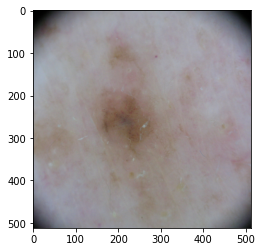

In [49]:
for item in dataset.take(1):
  patient_id = item[0].numpy()
  image_id = item[1].numpy()
  img = item[2].numpy()
  source = item[3].numpy()
  sex = item[4].numpy()
  age_approx = item[5].numpy()
  anatom_site_general_challenge = item[6].numpy()
  diagnosis = item[7].numpy()
  target = item[8].numpy()

print(patient_id, image_id, source, sex, age_approx, anatom_site_general_challenge, diagnosis, target)
plt.imshow(img)

In [50]:
combined_df.set_index('image_id').loc[image_id.decode()]

patient_id                       BCN_0001006
source                                ISIC19
sex                                     male
age_approx                                80
anatom_site_general_challenge      head/neck
diagnosis                                BCC
target                                     0
Name: ISIC_0057069, dtype: object

Full Image

In [0]:
dataset = MelanomaDataset(filenames=filenames)
dataset = dataset.load_dataset_from_tfrecord()

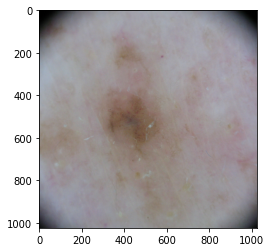

In [52]:
for item in dataset.take(1):
  patient_id = item[0].numpy()
  image_id = item[1].numpy()
  img = item[2].numpy()
  source = item[3].numpy()
  sex = item[4].numpy()
  age_approx = item[5].numpy()
  anatom_site_general_challenge = item[6].numpy()
  diagnosis = item[7].numpy()
  target = item[8].numpy()
  
plt.imshow(img)

### Upload to Kaggle

In [53]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Copy Kaggle API key
!mkdir -p ~/.kaggle && cp /content/drive/My\ Drive/Projects/Kaggle/api_key/kaggle.json ~/.kaggle/

In [55]:
!kaggle datasets init -p data/

Data package template written to: data/dataset-metadata.json


In [57]:
!kaggle datasets create -p data/

Starting upload for file train_orig_part_12_2070.tfrec
100% 1.52G/1.52G [00:29<00:00, 55.5MB/s]
Upload successful: train_orig_part_12_2070.tfrec (2GB)
Starting upload for file train_orig_part_1_2071.tfrec
100% 1.53G/1.53G [00:30<00:00, 53.8MB/s]
Upload successful: train_orig_part_1_2071.tfrec (2GB)
Starting upload for file train_orig_part_7_2070.tfrec
100% 1.50G/1.50G [00:29<00:00, 53.9MB/s]
Upload successful: train_orig_part_7_2070.tfrec (1GB)
Starting upload for file train_ext_part_9_1453.tfrec
100% 718M/718M [00:14<00:00, 53.7MB/s]
Upload successful: train_ext_part_9_1453.tfrec (718MB)
Starting upload for file train_ext_part_12_1453.tfrec
100% 713M/713M [00:13<00:00, 53.5MB/s]
Upload successful: train_ext_part_12_1453.tfrec (713MB)
Starting upload for file train_ext_part_5_1454.tfrec
100% 379M/379M [00:07<00:00, 53.1MB/s]
Upload successful: train_ext_part_5_1454.tfrec (379MB)
Starting upload for file train_orig_part_2_2071.tfrec
100% 1.49G/1.49G [00:29<00:00, 53.9MB/s]
Upload succes

In [59]:
!kaggle datasets status nisarahamedk/melanoma-dataset